In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/AML

/content/drive/MyDrive/AML


In [ ]:
%ls

adversarial_dataset.csv                           report.log              Train_data.csv
AML_blackbox.ipynb                                Test_data.csv           Train_data_with_adv.csv
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  Test_data_with_adv.csv


In [ ]:
!pip install pyswarms
!pip install pyswarm

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pyswarms.single import GlobalBestPSO
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Data Loading and Preprocessing
df = pd.read_csv('Train_data.csv', header=None, low_memory=False)
df.columns = df.iloc[0]
df = df[1:]
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
1,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0,0,0,0.05,0,normal
2,0,udp,other,SF,146,0,0,0,0,0,...,1,0,0.6,0.88,0,0,0,0,0,normal
3,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.1,0.05,0,0,1,1,0,0,anomaly
4,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1,0,0.03,0.04,0.03,0.01,0,0.01,normal
5,0,tcp,http,SF,199,420,0,0,0,0,...,255,1,0,0,0,0,0,0,0,normal


In [ ]:
le = LabelEncoder()
categorical_cols = ['protocol_type', 'service', 'flag']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
1,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0,0,0,0.05,0,normal
2,0,2,41,9,146,0,0,0,0,0,...,1,0,0.6,0.88,0,0,0,0,0,normal
3,0,1,46,5,0,0,0,0,0,0,...,26,0.1,0.05,0,0,1,1,0,0,anomaly
4,0,1,22,9,232,8153,0,0,0,0,...,255,1,0,0.03,0.04,0.03,0.01,0,0.01,normal
5,0,1,22,9,199,420,0,0,0,0,...,255,1,0,0,0,0,0,0,0,normal


In [ ]:
# Define columns to exclude from attack
EXCLUDED_COLS = ['protocol_type', 'flag', 'land', 'hot', 'root_shell', 'num_outbound_cmds']
X = df.drop(['class'] + EXCLUDED_COLS, axis=1)
excluded_data = df[EXCLUDED_COLS]
y = le.fit_transform(df['class'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Original Model Performance:
Accuracy: 0.9967
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3523
           1       0.99      1.00      1.00      4035

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



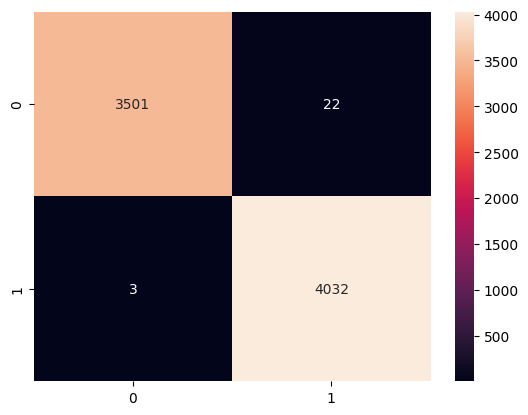

In [ ]:
# Evaluation function
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

# Initial evaluation
print("Original Model Performance:")
evaluate_model(rf, X_test, y_test)

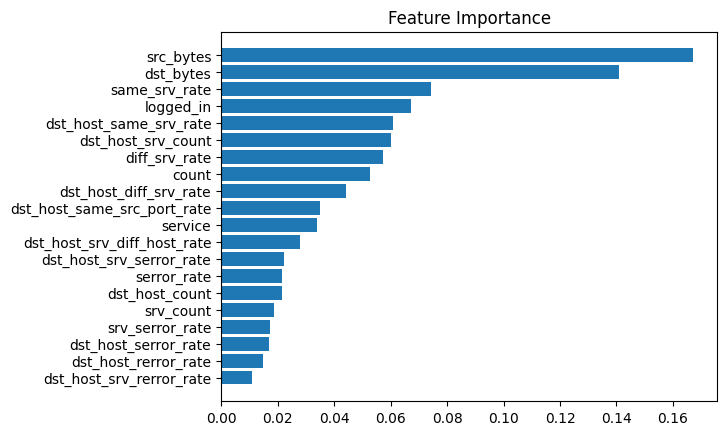

In [ ]:
# Feature importance
importances = rf.feature_importances_
features = X.columns
plt.barh(features[np.argsort(importances)[-20:]], importances[np.argsort(importances)[-20:]])
plt.title("Feature Importance")
plt.show()

In [ ]:
# Ensure all features are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X_train = X_train.dropna(axis=1)
X_test = X_test.dropna(axis=1)

# Update feature names
features = X_train.columns

In [ ]:
# PSO-based attack
def pso_attack(model, X_test, y_test):
    # PSO configuration
    options = {'c1': 0.7, 'c2': 0.4, 'w': 0.8}
    n_particles = 50
    max_iter = 200
    max_perturb = 5.0

    bounds = (np.full(X_test.shape[1], -max_perturb),
             np.full(X_test.shape[1], max_perturb))

    # Adversarial objective function
    def objective(perturbations):
        perturb_3d = perturbations.reshape((n_particles, 1, X_test.shape[1]))

        # Create perturbed dataset (n_particles, n_samples, n_features)
        perturbed_data = X_test + perturb_3d
        preds = model.predict(perturbed_data.reshape(-1, X_test.shape[1]))
        preds = preds.reshape(n_particles, -1)
        return np.mean(preds[:, y_test == 1] == 0, axis=1)

    # Initialize and run PSO
    optimizer = GlobalBestPSO(n_particles=n_particles,
                            dimensions=X_test.shape[1],
                            options=options,
                            bounds=bounds)
    cost, pos = optimizer.optimize(objective, iters=max_iter)

    return pos

In [ ]:
# Generate adversarial perturbations
print("\nGenerating adversarial perturbations with PSO...")
best_perturbation = pso_attack(rf, X_test.values, y_test)

2025-03-08 04:06:21,624 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.7, 'c2': 0.4, 'w': 0.8}



Generating adversarial perturbations with PSO...


pyswarms.single.global_best: 100%|██████████|200/200, best_cost=0
2025-03-08 04:13:13,960 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [ 4.17486211  0.88652333 -1.01421852  4.19617004  1.3995647   3.5898476
  1.77880196  3.01785432  0.47208605 -3.1400735   2.69487841  3.04524237
 -0.26572483  4.09727008  2.23755801  4.98335874 -2.5213076   2.68327665
  1.27593268 -1.43954214  4.61891132  1.75338595  0.91143503  2.84727036
 -2.30043991 -2.91015931 -1.33865432 -0.9188302  -0.7080424  -3.11324511
 -1.75494053  2.36388309 -3.24213495 -0.98739231 -1.26539643]



Adversarial dataset saved as adversarial_dataset.csv

Evaluating Original Model on Adversarial Data:
Accuracy: 0.8612
              precision    recall  f1-score   support

           0       1.00      0.70      0.83      3523
           1       0.79      1.00      0.88      4035

    accuracy                           0.86      7558
   macro avg       0.90      0.85      0.86      7558
weighted avg       0.89      0.86      0.86      7558



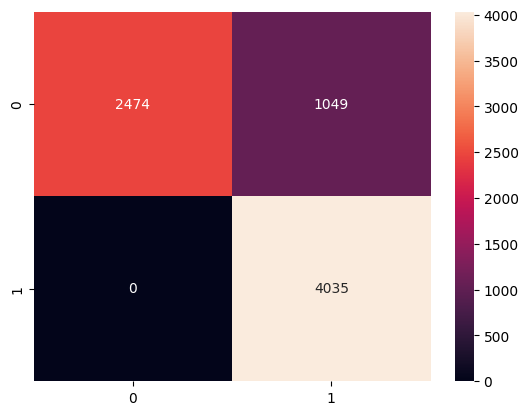

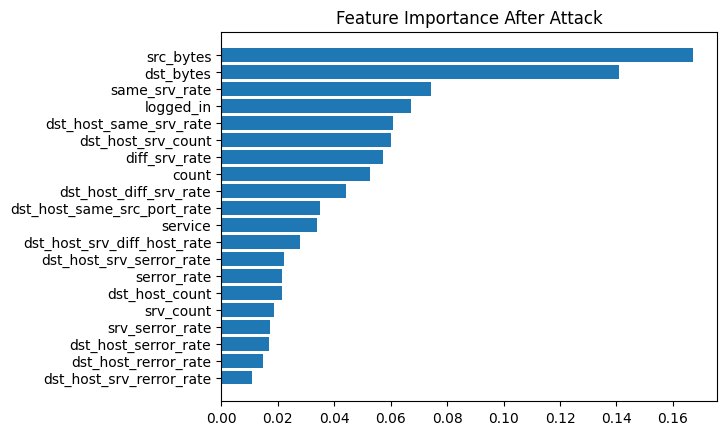

In [ ]:
# Create adversarial dataset
X_adv = X_test.copy()
X_adv.iloc[:, :] = X_test.values + best_perturbation

# Save adversarial dataset
adv_filename = 'adversarial_dataset.csv'
X_adv.to_csv(adv_filename, index=False)
print(f"\nAdversarial dataset saved as {adv_filename}")

# Evaluate original model on adversarial data
print("\nEvaluating Original Model on Adversarial Data:")
evaluate_model(rf, X_adv, y_test)

# Feature importance after attack
importances_adv = rf.feature_importances_
plt.barh(features[np.argsort(importances_adv)[-20:]],
        importances_adv[np.argsort(importances_adv)[-20:]])
plt.title("Feature Importance After Attack")
plt.show()

In [ ]:
# Perturbation analysis
perturbation_analysis = pd.DataFrame({
    'Feature': features,
    'Perturbation': best_perturbation,
    'Absolute_Perturbation': np.abs(best_perturbation)
}).sort_values('Absolute_Perturbation', ascending=False)

print("\nTop 10 Most Perturbed Features:")
print(perturbation_analysis.head(10))


Top 10 Most Perturbed Features:
                        Feature  Perturbation  Absolute_Perturbation
15               is_guest_login      4.983359               4.983359
20                  rerror_rate      4.618911               4.618911
3                     dst_bytes      4.196170               4.196170
0                      duration      4.174862               4.174862
13             num_access_files      4.097270               4.097270
5                        urgent      3.589848               3.589848
32     dst_host_srv_serror_rate     -3.242135               3.242135
9                  su_attempted     -3.140073               3.140073
29  dst_host_same_src_port_rate     -3.113245               3.113245
11           num_file_creations      3.045242               3.045242



Training New Model on Adversarial Data...

Adversarial Model Evaluation:
Accuracy: 0.9966
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3523
           1       1.00      1.00      1.00      4035

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558



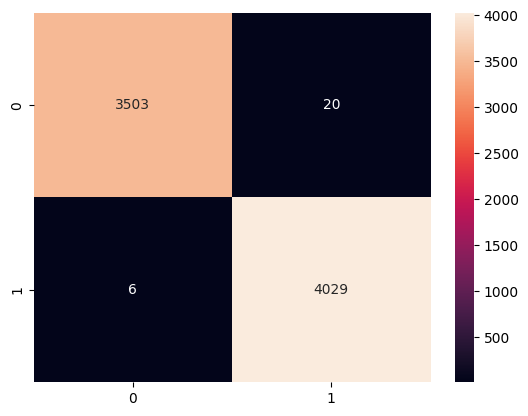

In [ ]:
# Train  model on adversarial data
print("\nTraining New Model on Adversarial Data...")
X_combined = pd.concat([X_train, X_adv])
y_combined = np.concatenate([y_train, y_test])
rf_adv = RandomForestClassifier(n_estimators=100, random_state=42)
rf_adv.fit(X_combined, y_combined)

# Evaluate new model
print("\nAdversarial Model Evaluation:")
evaluate_model(rf_adv, X_test, y_test)

In [ ]:
# Autoencoder-based Adversarial Detection
def train_adversarial_detector(X_clean):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_clean)

    input_dim = X_scaled.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(0.001), loss='mse')

    autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, verbose=0)

    reconstructions = autoencoder.predict(X_scaled, verbose=0)
    mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
    threshold = np.percentile(mse, 95)

    return autoencoder, threshold, scaler

print("\nTraining Autoencoder-based Adversarial Detector...")
detector, threshold, scaler = train_adversarial_detector(X_train)



Training Autoencoder-based Adversarial Detector...


In [ ]:
# Autoencoder Defense Mechanism
def defend_against_attack(model, detector, threshold, scaler, X_test):
    X_scaled = scaler.transform(X_test)
    reconstructions = detector.predict(X_scaled, verbose=0)
    mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
    is_adversarial = mse > threshold

    if np.any(is_adversarial):
        print(f"WARNING: {np.sum(is_adversarial)} adversarial samples detected!")
        clean_samples = X_test[~is_adversarial]
        if clean_samples.shape[0] > 0:
            return model.predict(clean_samples), is_adversarial
        else:
            return None, is_adversarial
    else:
        return model.predict(X_test), is_adversarial

print("\nTesting Defense Mechanism on Adversarial Dataset:")
y_pred_defended, is_adversarial = defend_against_attack(rf, detector, threshold, scaler, X_adv)

if y_pred_defended is not None:
    clean_indices = ~is_adversarial
    print("\nModel Performance on Clean Samples:")
    print(f"Accuracy: {accuracy_score(y_test[clean_indices], y_pred_defended):.4f}")
    print(classification_report(y_test[clean_indices], y_pred_defended))



Testing Defense Mechanism on Adversarial Dataset:


In [ ]:
# Adversarial Training
def adversarial_training(model, X_train, y_train, X_adv, y_adv, epochs=5):
    for epoch in range(epochs):
        X_combined = np.vstack([X_train, X_adv])
        y_combined = np.hstack([y_train, y_adv])
        model.fit(X_combined, y_combined)
        print(f"Epoch {epoch + 1}/{epochs} complete.")
    return model

y_adv = np.zeros(X_adv.shape[0])
print("\nTraining Robust Model with Adversarial Training...")
rf_robust = RandomForestClassifier(n_estimators=100, random_state=42)
rf_robust = adversarial_training(rf_robust, X_train, y_train, X_adv, y_adv)

print("\nEvaluating Robust Model on Adversarial Dataset:")
y_pred_robust = rf_robust.predict(X_adv)
print(f"Accuracy: {accuracy_score(y_test, y_pred_robust):.4f}")
print(classification_report(y_test, y_pred_robust))


Training Robust Model with Adversarial Training...
Epoch 1/5 complete.
Epoch 2/5 complete.
Epoch 3/5 complete.
Epoch 4/5 complete.
Epoch 5/5 complete.

Evaluating Robust Model on Adversarial Dataset:
Accuracy: 0.4661
              precision    recall  f1-score   support

           0       0.47      1.00      0.64      3523
           1       0.00      0.00      0.00      4035

    accuracy                           0.47      7558
   macro avg       0.23      0.50      0.32      7558
weighted avg       0.22      0.47      0.30      7558



### SVM based defence

In [ ]:
# Create adversarial dataset
X_adv = X_test.copy()
X_adv.iloc[:, :] = X_test.values + best_perturbation

# Save adversarial dataset
adv_filename = 'adversarial_dataset.csv'
X_adv.to_csv(adv_filename, index=False)
print(f"\nAdversarial dataset saved as {adv_filename}")

# Evaluate original model on adversarial data
print("\nEvaluating Original Model on Adversarial Data:")
evaluate_model(rf, X_adv, y_test)

# Feature importance after attack
importances_adv = rf.feature_importances_
plt.barh(features[np.argsort(importances_adv)[-20:]],
        importances_adv[np.argsort(importances_adv)[-20:]])
plt.title("Feature Importance After Attack")
plt.show()

In [ ]:
# Perturbation analysis
perturbation_analysis = pd.DataFrame({
    'Feature': features,
    'Perturbation': best_perturbation,
    'Absolute_Perturbation': np.abs(best_perturbation)
}).sort_values('Absolute_Perturbation', ascending=False)

print("\nTop 10 Most Perturbed Features:")
print(perturbation_analysis.head(10))

In [ ]:
# Train new model on adversarial data
print("\nTraining New Model on Adversarial Data...")
X_combined = pd.concat([X_train, X_adv])
y_combined = np.concatenate([y_train, y_test])
rf_adv = RandomForestClassifier(n_estimators=100, random_state=42)
rf_adv.fit(X_combined, y_combined)

# Evaluate new model
print("\nAdversarial Model Evaluation:")
evaluate_model(rf_adv, X_test, y_test)

In [ ]:
# Adversarial Detection System
def train_adversarial_detector(X_clean, X_adv):
    # Label clean data as 0 and adversarial data as 1
    X_detection = np.vstack([X_clean, X_adv])
    y_detection = np.hstack([np.zeros(X_clean.shape[0]), np.ones(X_adv.shape[0])])

    # Train a One-Class SVM for adversarial detection
    detector = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
    detector.fit(X_detection)
    return detector

# Train adversarial detector
detector = train_adversarial_detector(X_train, X_adv)

In [ ]:

# Defense Mechanism
def defend_against_attack(model, detector, X_test):
    # Detect adversarial samples
    is_adversarial = detector.predict(X_test) == -1  # SVM predicts -1 for outliers

    if np.any(is_adversarial):
        print("WARNING: Adversarial samples detected in the dataset!")
        print(f"Number of adversarial samples: {np.sum(is_adversarial)}")

        # Only predict on clean samples
        clean_samples = X_test[~is_adversarial]
        if clean_samples.shape[0] > 0:
            print("Making predictions on clean samples only...")
            return model.predict(clean_samples), is_adversarial
        else:
            print("No clean samples found. Aborting predictions.")
            return None, is_adversarial
    else:
        print("No adversarial samples detected. Proceeding with predictions...")
        return model.predict(X_test), is_adversarial


In [ ]:
# Test defense mechanism
print("\nTesting Defense Mechanism on Adversarial Dataset:")
y_pred_defended, is_adversarial = defend_against_attack(rf, detector, X_adv)

if y_pred_defended is not None:
    clean_indices = ~is_adversarial
    print("\nModel Performance on Clean Samples:")
    print(f"Accuracy: {accuracy_score(y_test[clean_indices], y_pred_defended):.4f}")
    print(classification_report(y_test[clean_indices], y_pred_defended))

In [ ]:

# Robust Model Training (Adversarial Training)
def adversarial_training(model, X_train, y_train, X_adv, y_adv, epochs=5):
    for epoch in range(epochs):
        # Combine clean and adversarial data
        X_combined = np.vstack([X_train, X_adv])
        y_combined = np.hstack([y_train, y_adv])

        # Retrain model
        model.fit(X_combined, y_combined)
        print(f"Epoch {epoch + 1}/{epochs} complete.")
    return model

# Generate adversarial labels (assuming attack targets class 0)
y_adv = np.zeros(X_adv.shape[0])  # All adversarial samples are labeled as normal (class 0)

# Train robust model
print("\nTraining Robust Model with Adversarial Training...")
rf_robust = RandomForestClassifier(n_estimators=100, random_state=42)
rf_robust = adversarial_training(rf_robust, X_train, y_train, X_adv, y_adv)

# Evaluate robust model
print("\nEvaluating Robust Model on Adversarial Dataset:")
y_pred_robust = rf_robust.predict(X_adv)
print(f"Accuracy: {accuracy_score(y_test, y_pred_robust):.4f}")
print(classification_report(y_test, y_pred_robust))